In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torcheval.metrics.functional import r2_score
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
from Distances import Distances
sys.path.insert(1,'../code/data_utils/')
from HiCMap import HiCMap
from HiCDataset import HiCDataset
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [2]:
region_length = 1_280_000
data_dir = '../data/samples/origami_64_no_embed_reduction/eval_mode/'
cond_scale=5.
rescaled_phi=8.
milestone=120

In [3]:
exp_hic = HiCDataset('../data/outside/GM12878_hg19.mcool')

In [4]:
regions = {
    '3':[5,100],
    '4':[77,218],
    '11':[54],
    '13':[166,302],
    '14':[174,335,519],
    '15':[930,1322],
    '16':[12,549],
    '17':[22,707],
    '18':[13],
    '20':[15,186],
    '22':[464,675],
    'X':[4756] # for high K27 content
}

In [5]:
def get_genomic_index(chrom,region_idx,rosetta=pd.read_pickle('../data/embeddings_64_after_transformer/rosetta_stone.pkl')):
    return rosetta[chrom][region_idx][-1]
    

In [6]:
def plot_region(
    chrom,
    region_idx,
    r_c=2,#1.5, # CUTOFF 2 because https://doi.org/10.1038/nature21429
    exp_hic=exp_hic,
    region_length=region_length,
    data_dir=data_dir,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    fig=None,
    ax=None,
    modify_vmin=False,
    threshold=False,
    sigma=3.72
):

    # Get experimental Hi-C
    start = get_genomic_index(chrom,region_idx)
    stop = start + region_length
    exp_map = exp_hic.fetch(chrom,start,stop)

    # Normalize the experimental Hi-C to nearest neighbor contact probabilities
    n = exp_map.prob_map.shape[-1]
    exp_map.prob_map/= torch.nanmean(exp_map.prob_map[range(n-1),range(1,n)])

    # Get simulated conformations, threshold to Hi-C
    fp = data_dir + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_{milestone}_{chrom}.pt'
    if threshold:
        p = (Coordinates(fp).distances.values < r_c).float().mean(0)
    else:
        p = Coordinates(fp).distances.values
        mask = p < r_c
        p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
        mask^= True
        p[mask] = (r_c/p[mask])**4 / 2
        p = p.mean(0)
    gen_map = HiCMap(p)

    vmin = exp_map.prob_map[exp_map.prob_map.isfinite()].min() if modify_vmin else None
    fig,ax,im,cbar = exp_map.plot_with(gen_map,fig=fig,ax=ax,vmin=vmin)
    ax.set_xlabel('Genomic index')
    ax.set_ylabel('Genomic index')
    start_Mb = round(start/1e6,3)
    stop_Mb = round(stop/1e6,3)
    ax.set_title(f'Chromosome {chrom}:' + '\n' + f'{start_Mb}-{stop_Mb} Mb')
    cbar.set_label('Interaction frequency')

    return fig, ax, im, cbar


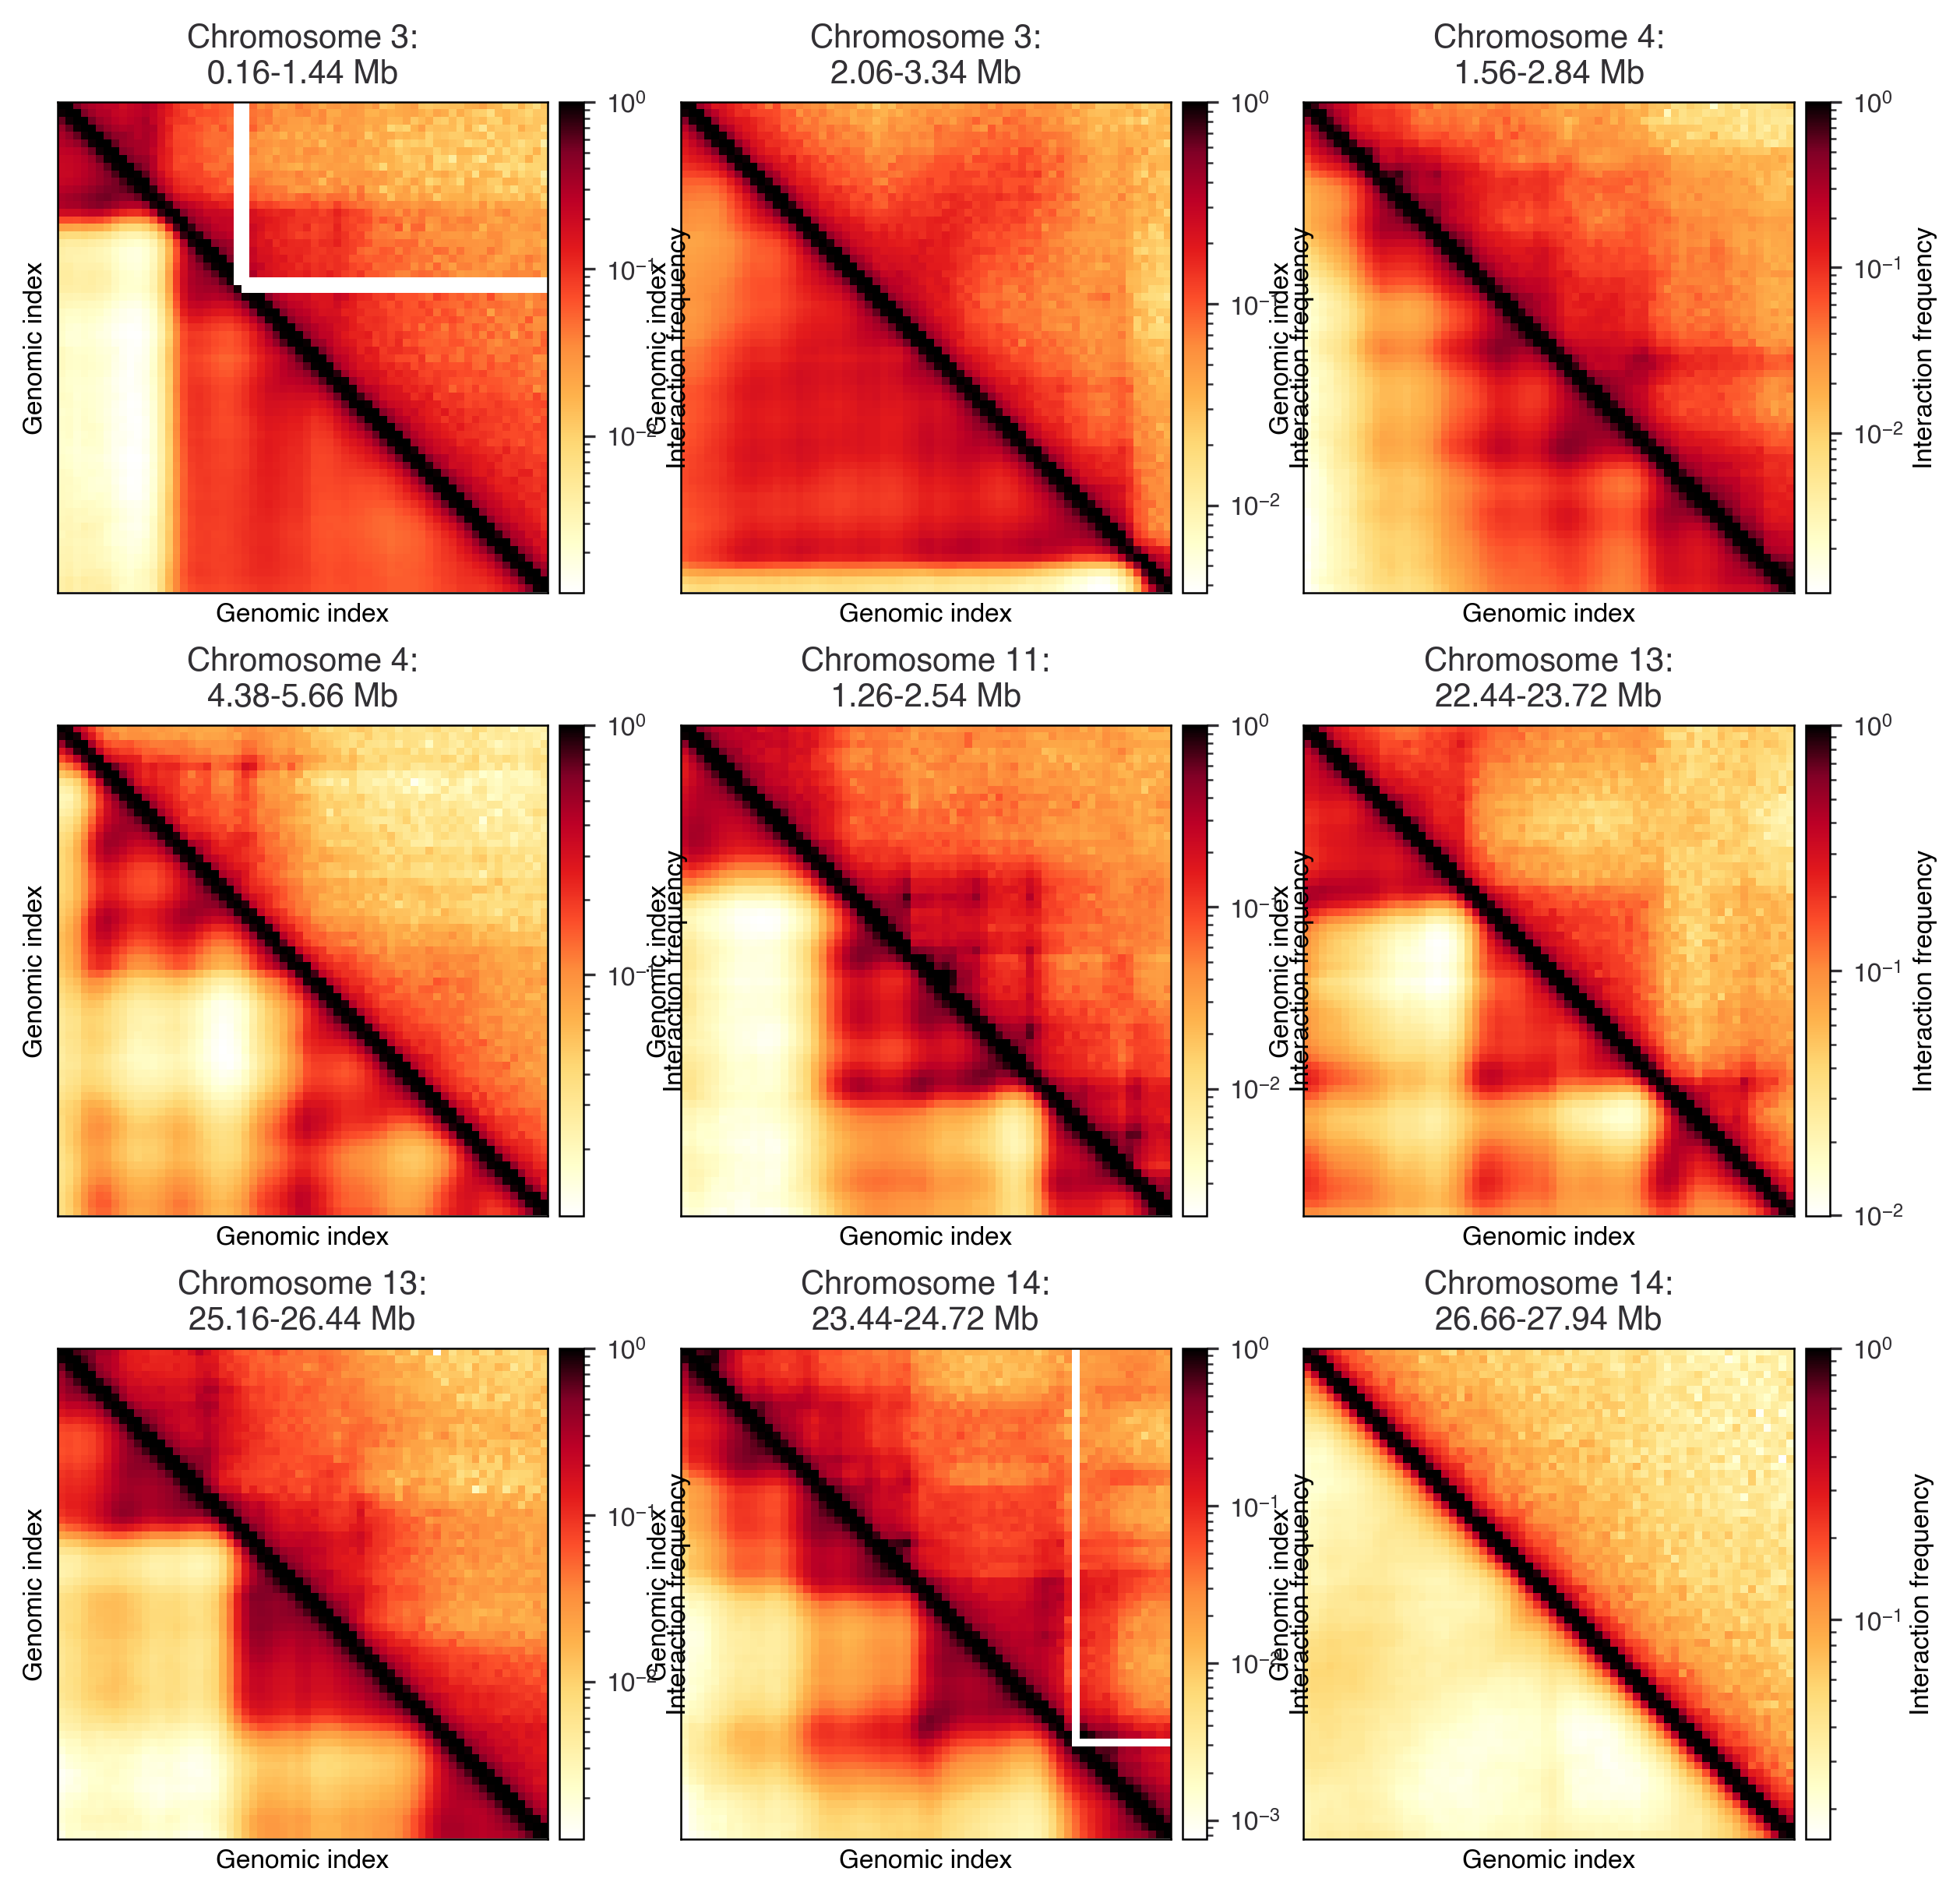

In [7]:
fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8))

n = 0 
for chrom,region_idxs in regions.items():
    for region_idx in region_idxs:
        ax = axes[n//3,n%3]
        fig, ax, im, cbar = plot_region(chrom,region_idx,fig=fig,ax=ax)
        n+=1
        if n >= 9:
            break
    if n >= 9:
        break

        
        

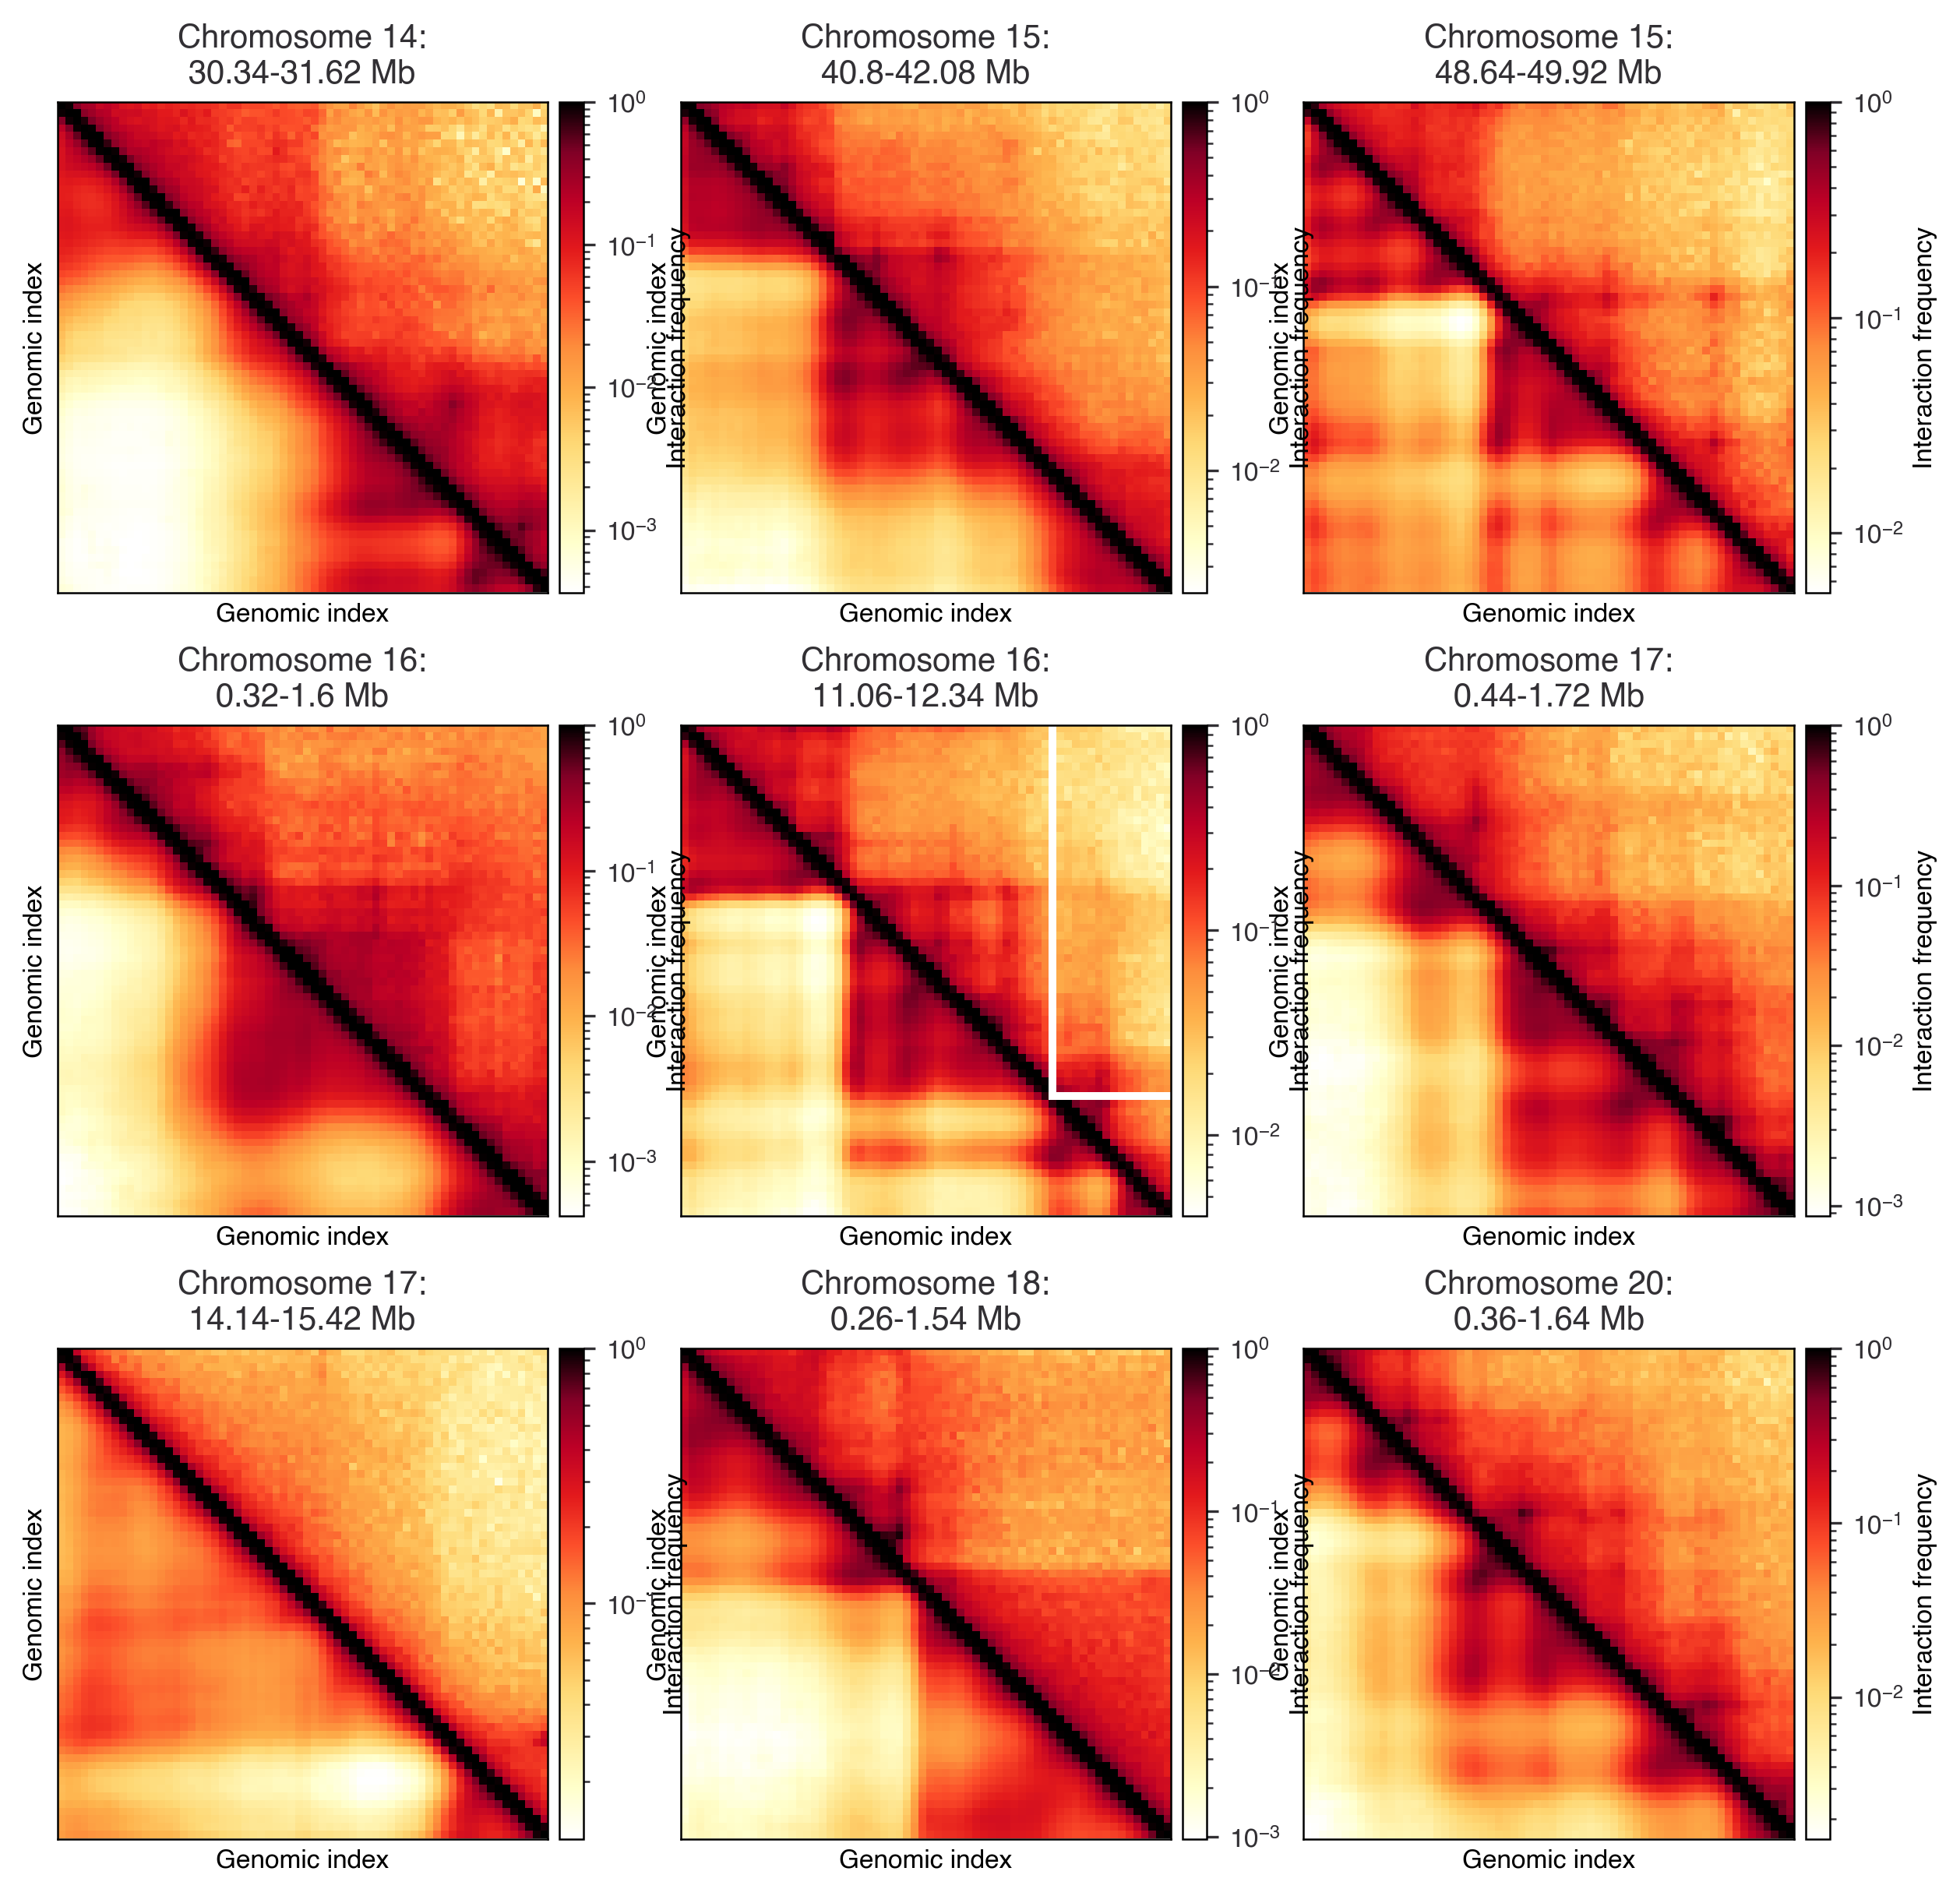

In [8]:
fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8))

n = 0 
for chrom,region_idxs in regions.items():
    for region_idx in region_idxs:
        if n < 9:
            n+=1
            continue

        m = n-9
        ax = axes[m//3,m%3]
        fig, ax, im, cbar = plot_region(chrom,region_idx,fig=fig,ax=ax)
        n+=1
        if n >= 18:
            break
    if n >= 18:
        break

        
        

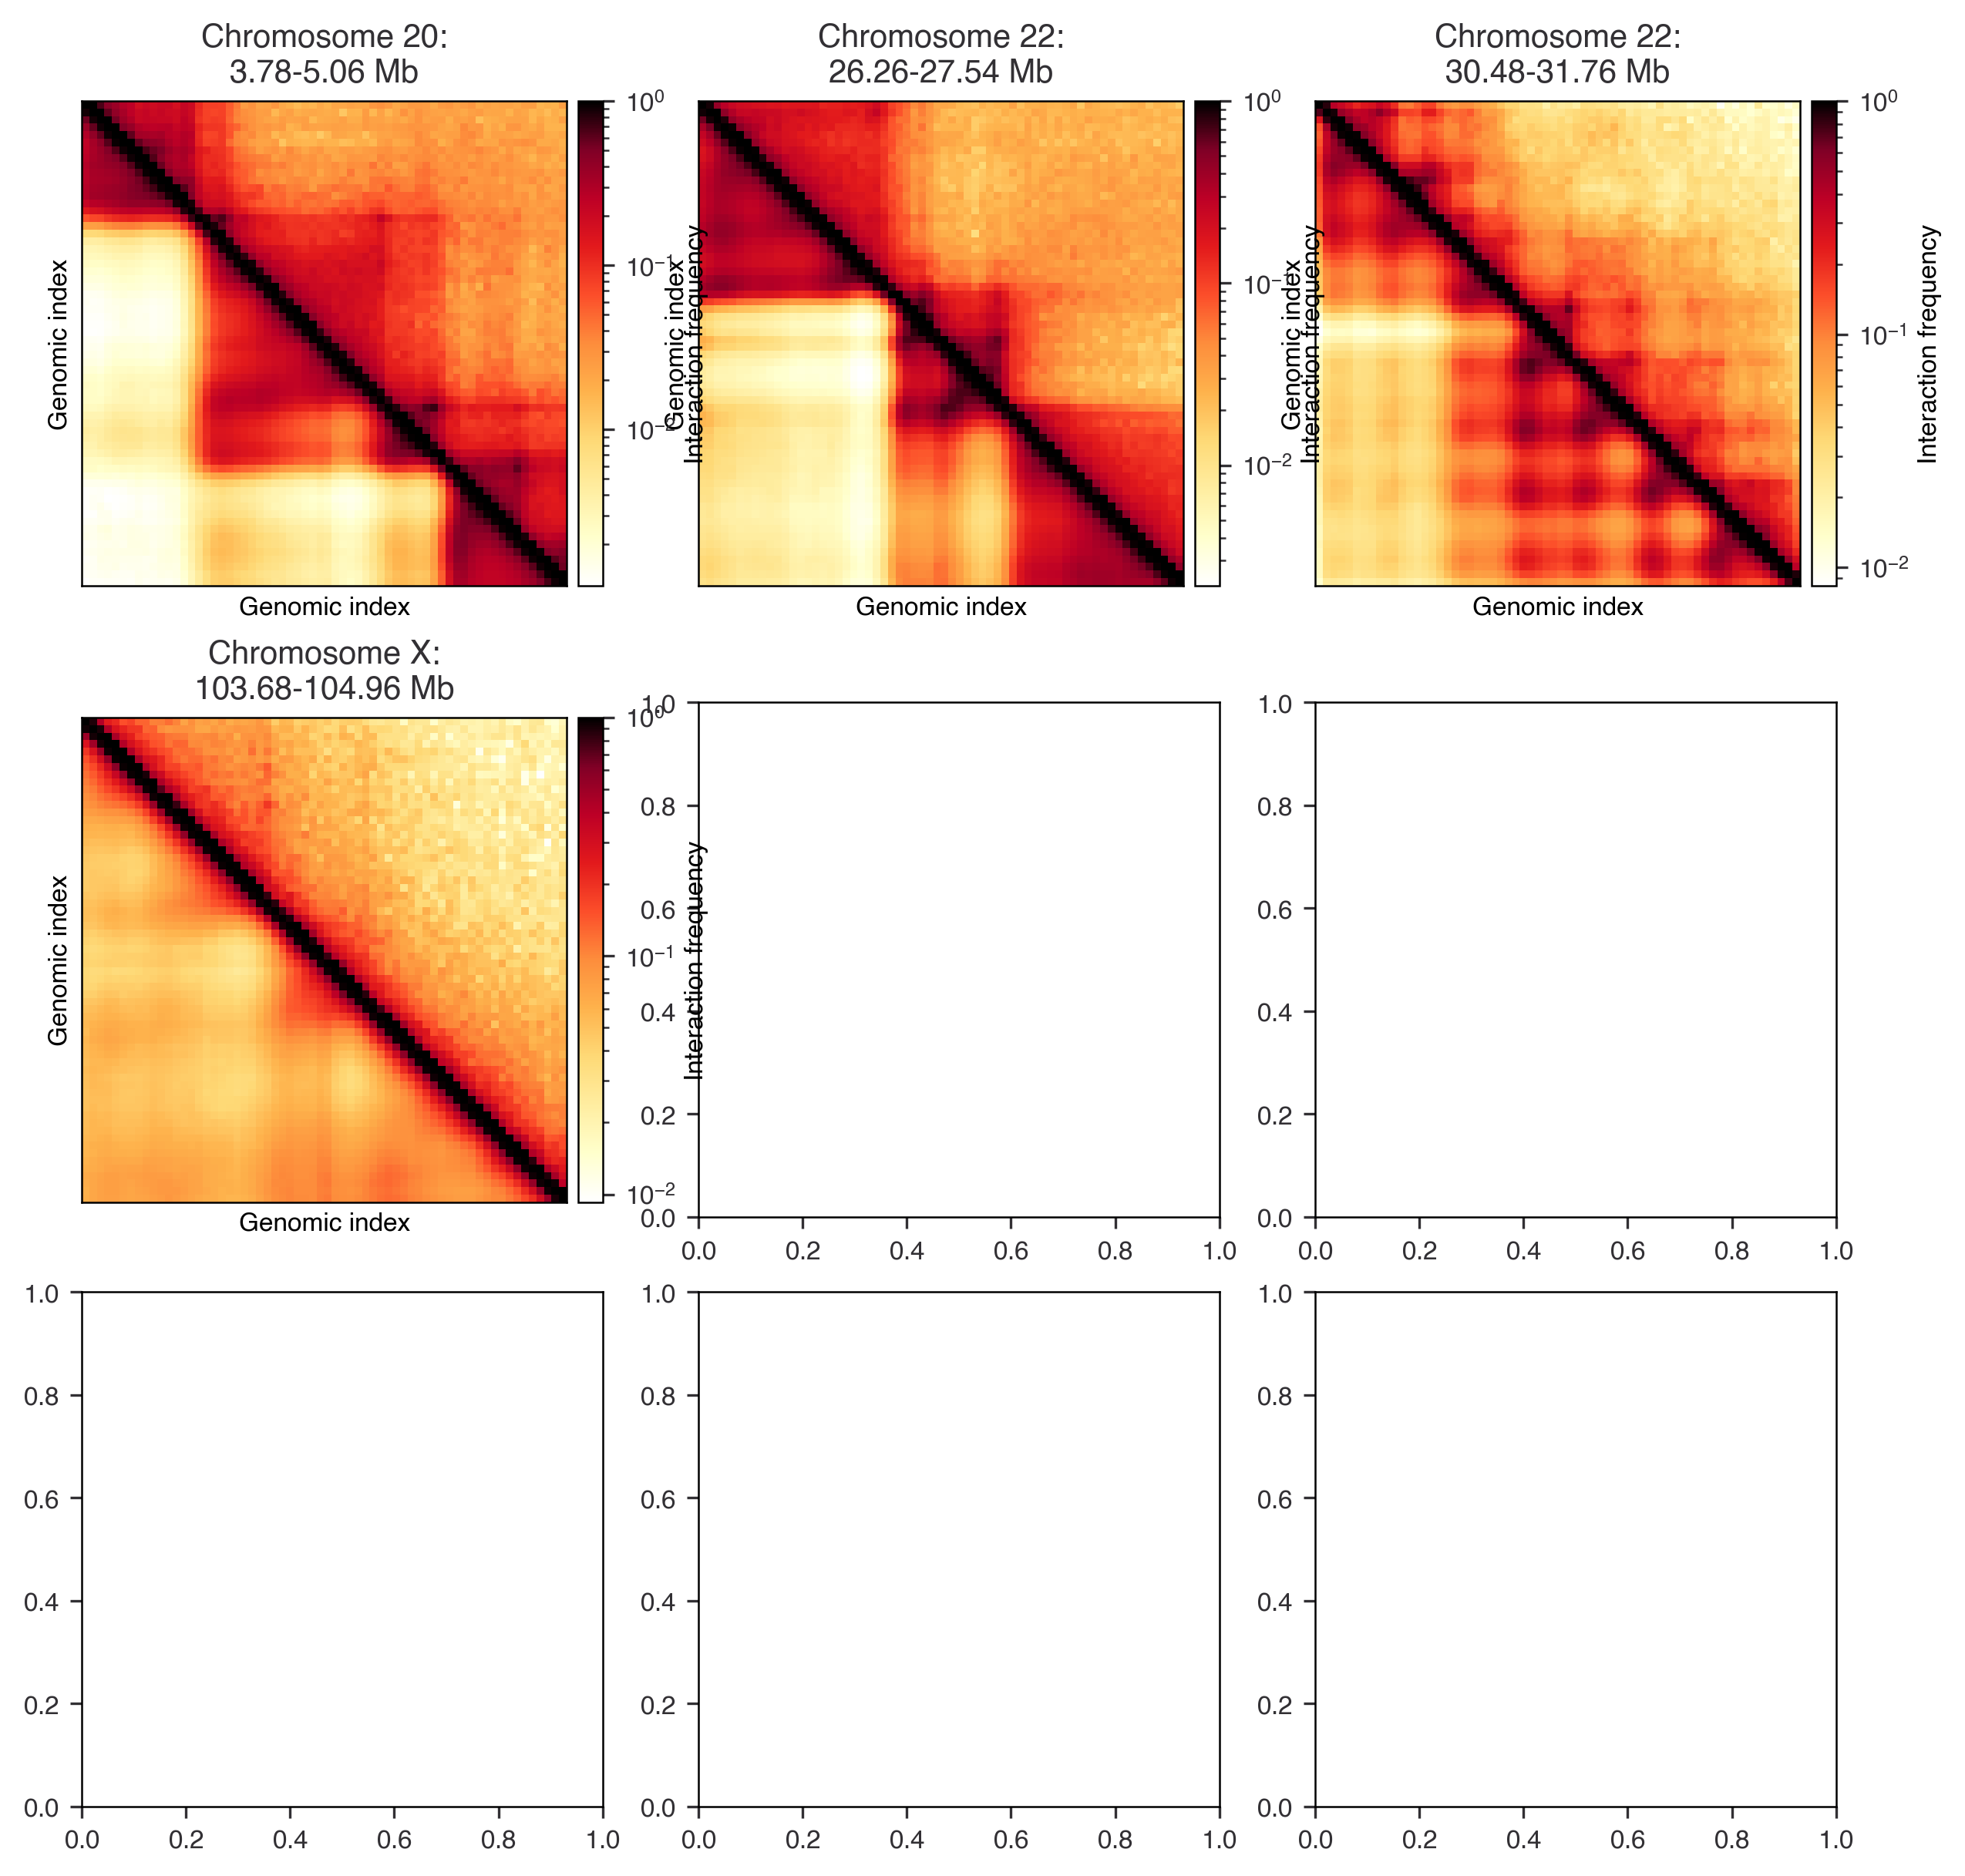

In [9]:
fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8))

n = 0 
for chrom,region_idxs in regions.items():
    for region_idx in region_idxs:
        if n < 18:
            n+=1
            continue

        m = n-18
        ax = axes[m//3,m%3]
        fig, ax, im, cbar = plot_region(chrom,region_idx,fig=fig,ax=ax)
        n+=1
        if n >= 27:
            break
    if n >= 27:
        break

        
        

#### Scatter plot + R-squared values

In [10]:
gm_directories = [
    '../data/samples/origami_64_no_embed_reduction/eval_mode/',
    '../data/samples/origami_64_no_embed_reduction/cross_validation/GM/',
]
imr_directories = [
    '../data/samples/origami_64_no_embed_reduction/cross_validation/IMR/',
]

In [12]:
def parse_filename(f):
    f = f.split('_')
    if f[0] == 'sample':
        chrom = f[-1].split('.')[0]
        region_idx = int(f[1])
    elif f[0] == 'chr':
        chrom = f[1]
        region_idx = int(f[2])
    else:
        raise Exception(f"File {'_'.join(f)} cannot be interpreted")
    genomic_index = get_genomic_index(chrom,region_idx)
    return chrom, region_idx, genomic_index

In [108]:
def get_gen_hic(fp,r_c=1.5,sigma=3.72):

    if type(fp) == torch.Tensor:
        p = fp.clone()
    elif type(fp) == str:
        p = Coordinates(fp).distances.values
    else:
        p=fp.distances.values
        
    mask = p < r_c
    p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
    mask^= True
    p[mask] = (r_c/p[mask])**4 / 2
    p = p.mean(0)

    return p
    return HiCMap(p)

In [188]:
from tqdm.auto import tqdm

i,j = torch.triu_indices(64,64,1)
nearest_neighbors = torch.where(j-i==1)[0]
r2_vals = []
r_c_vals = []
sigma_vals = []
hic_corrcoefs = []

r_c_unique = torch.tensor([2.])#torch.arange(1.9,2.1,.02)
sigma_unique = torch.tensor([2.]) #torch.arange(1.,6.1,.25)

files = {}
n = 0
for d in gm_directories:
    files[d] = [ f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]
    n+= len(files[d])

with tqdm(initial=0,total=len(r_c_unique)*len(sigma_unique)*n) as pbar:
    for d,fs in files.items():
        for f in fs:
            chrom,region_idx,start = parse_filename(f)
            
            exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
            exp_probs = exp_map.prob_map[i,j]
            exp_probs/= torch.nanmean(exp_probs[nearest_neighbors])
            idx = torch.where(exp_probs.isfinite())[0]
            
            exp_probs = exp_probs[idx]
            
            coords = Coordinates(d+f).distances.values[...,i,j]
    
            for r_c in r_c_unique:
                for sigma in sigma_unique:
            
                    gen_map = get_gen_hic(coords,r_c=r_c,sigma=sigma)
                    #gen_probs = gen_map.prob_map[i,j]
                    gen_probs = gen_map 
                    
                    #idx = torch.where(exp_probs.isfinite())[0]
                    r2_vals.append(r2_score(gen_probs[idx],exp_probs))

                    hic_corrcoefs.append(
                        torch.corrcoef(
                            torch.stack([gen_probs[idx],exp_probs],dim=0)
                        )[0,1]
                    )
                    
                    r_c_vals.append(r_c)
                    sigma_vals.append(sigma)
                    pbar.update(1)
'''
for r_c in torch.arange(1,2.1,.1):
    for sigma in torch.arange(3.,4.1,.1):
        for d in gm_directories:
            files = [ f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]
            for f in files:
                chrom,region_idx,start = parse_filename(f)
                
                exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
                exp_probs = exp_map.prob_map[i,j]
                exp_probs/= torch.nanmean(exp_probs[nearest_neighbors])
                
                gen_map = get_gen_hic(d+f,r_c=r_c,sigma=sigma)
                gen_probs = gen_map.prob_map[i,j]
                
                idx = torch.where(exp_probs.isfinite())[0]
                r2_vals.append(r2_score(gen_probs[idx],exp_probs[idx]))
                
                r_c_vals.append(r_c)
                sigma_vals.append(sigma)
'''
r_c_vals = torch.tensor(r_c_vals)
sigma_vals = torch.tensor(sigma_vals)
r2_vals = torch.tensor(r2_vals)
hic_corrcoefs = torch.tensor(hic_corrcoefs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [135]:
r_c_unique = r_c_vals.unique()
sigma_unique = sigma_vals.unique()

data = torch.empty(len(sigma_unique),len(r_c_unique)).fill_(torch.nan)
for i,s in enumerate(sigma_unique):
    idx1 = sigma_vals == s
    for j,r in enumerate(r_c_unique):
        idx2 = idx1 & (r_c_vals == r)
        data[i,j] = r2_vals[idx2].mean()

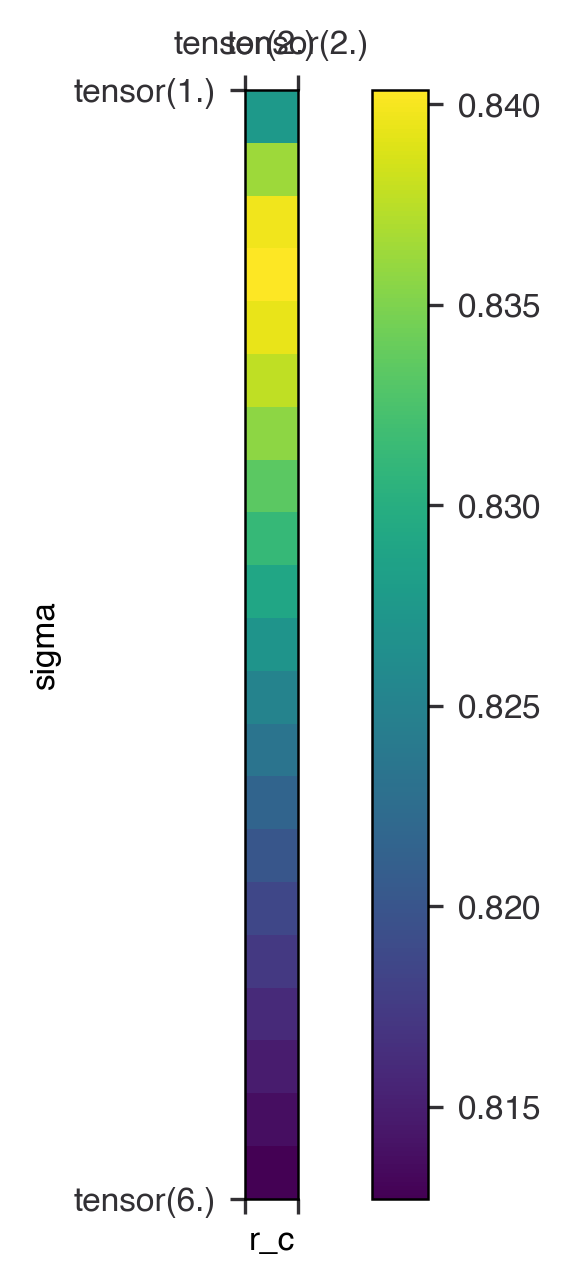

In [136]:
fig=plt.figure()
ax=fig.add_subplot(111)
im=ax.matshow(data)
ax.set_xlabel('r_c')
ax.set_ylabel('sigma')
ax.set_xticks(ax.get_xlim(),labels=[str(r_c_unique[0]),str(r_c_unique[-1])])
ax.set_yticks(ax.get_ylim(),labels=[str(sigma_unique[-1]),str(sigma_unique[0])])
fig.colorbar(im)

Text(0, 0.5, 'Analyzing match between experimental and inferred Hi-C')

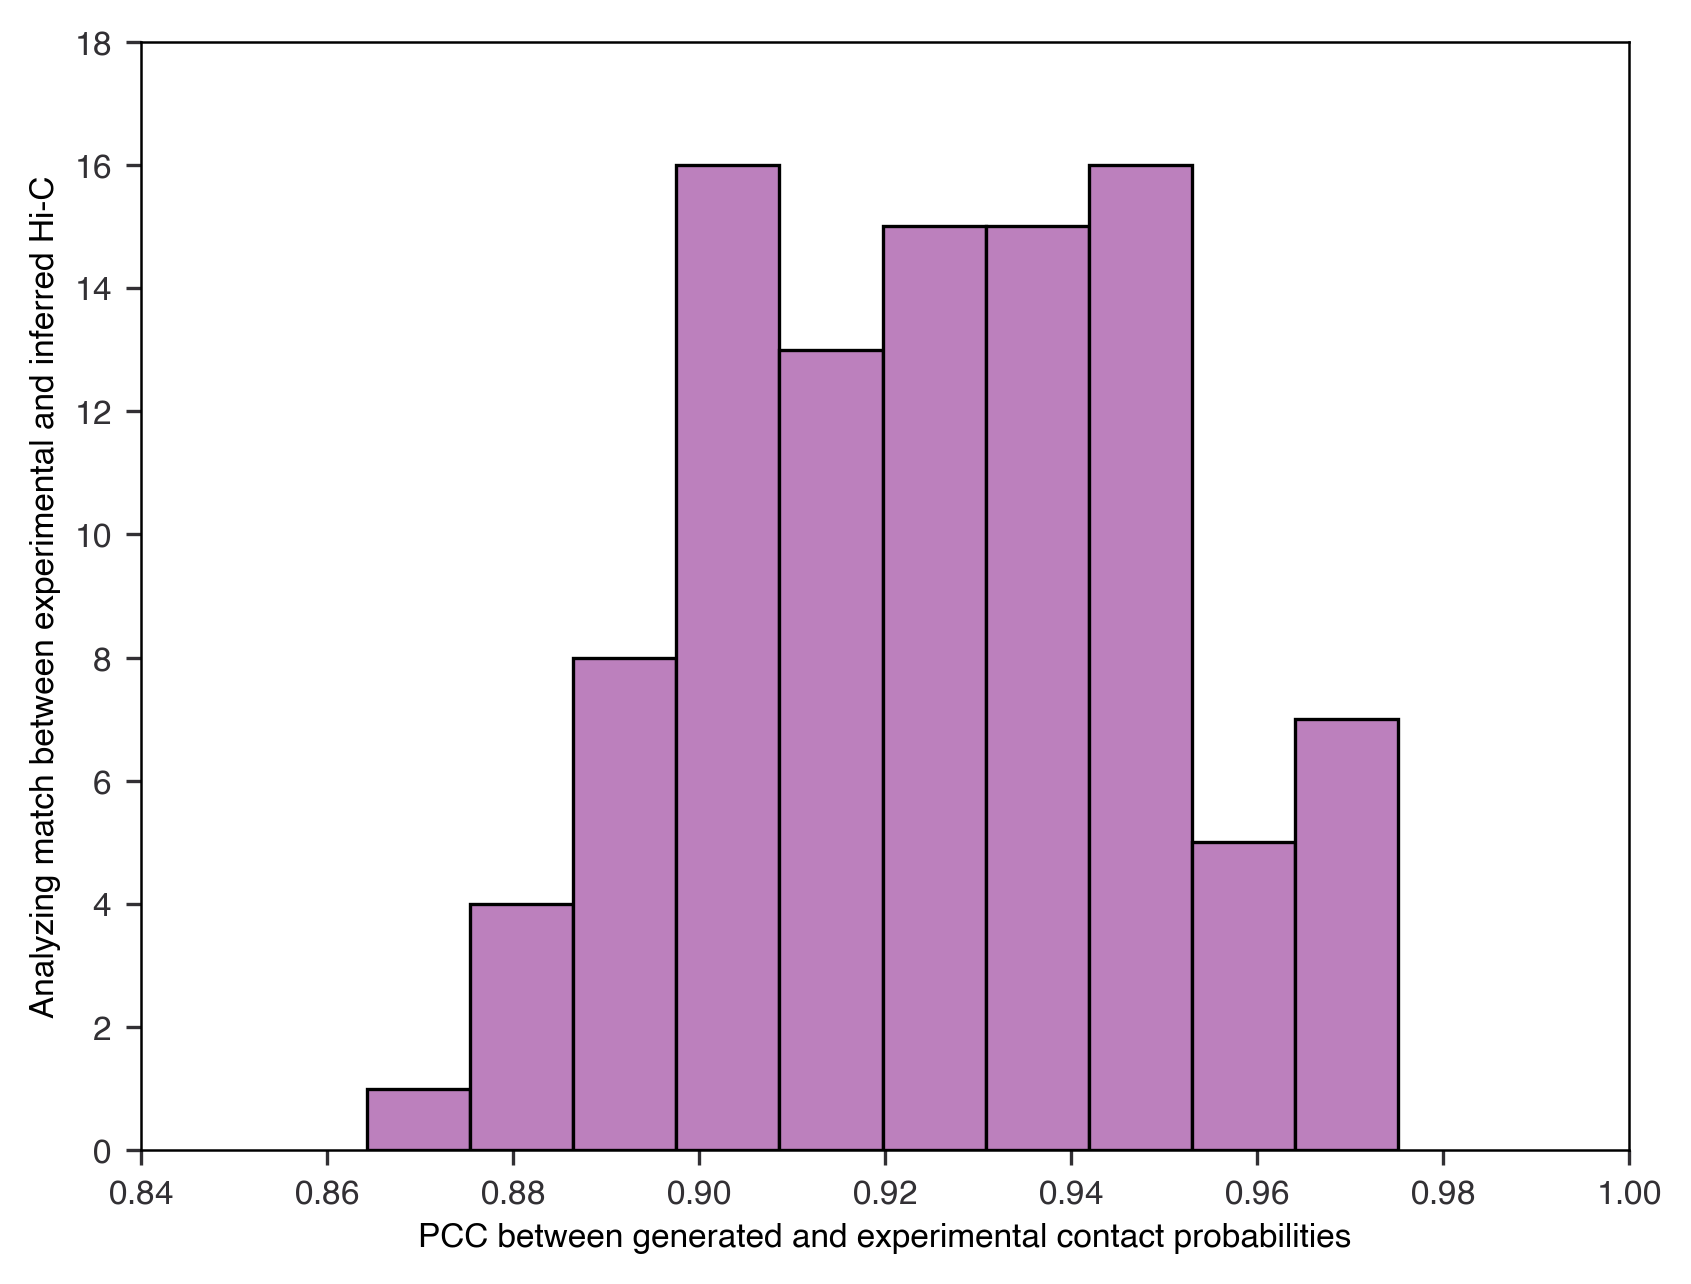

In [191]:
plt.hist(hic_corrcoefs.numpy())#,density=True)
plt.xlabel('PCC between generated and experimental contact probabilities')
plt.ylabel('Number of regions')
plt.ylabel('Analyzing match between experimental and inferred Hi-C')

Text(0, 0.5, 'Analyzing match between experimental and inferred Hi-C')

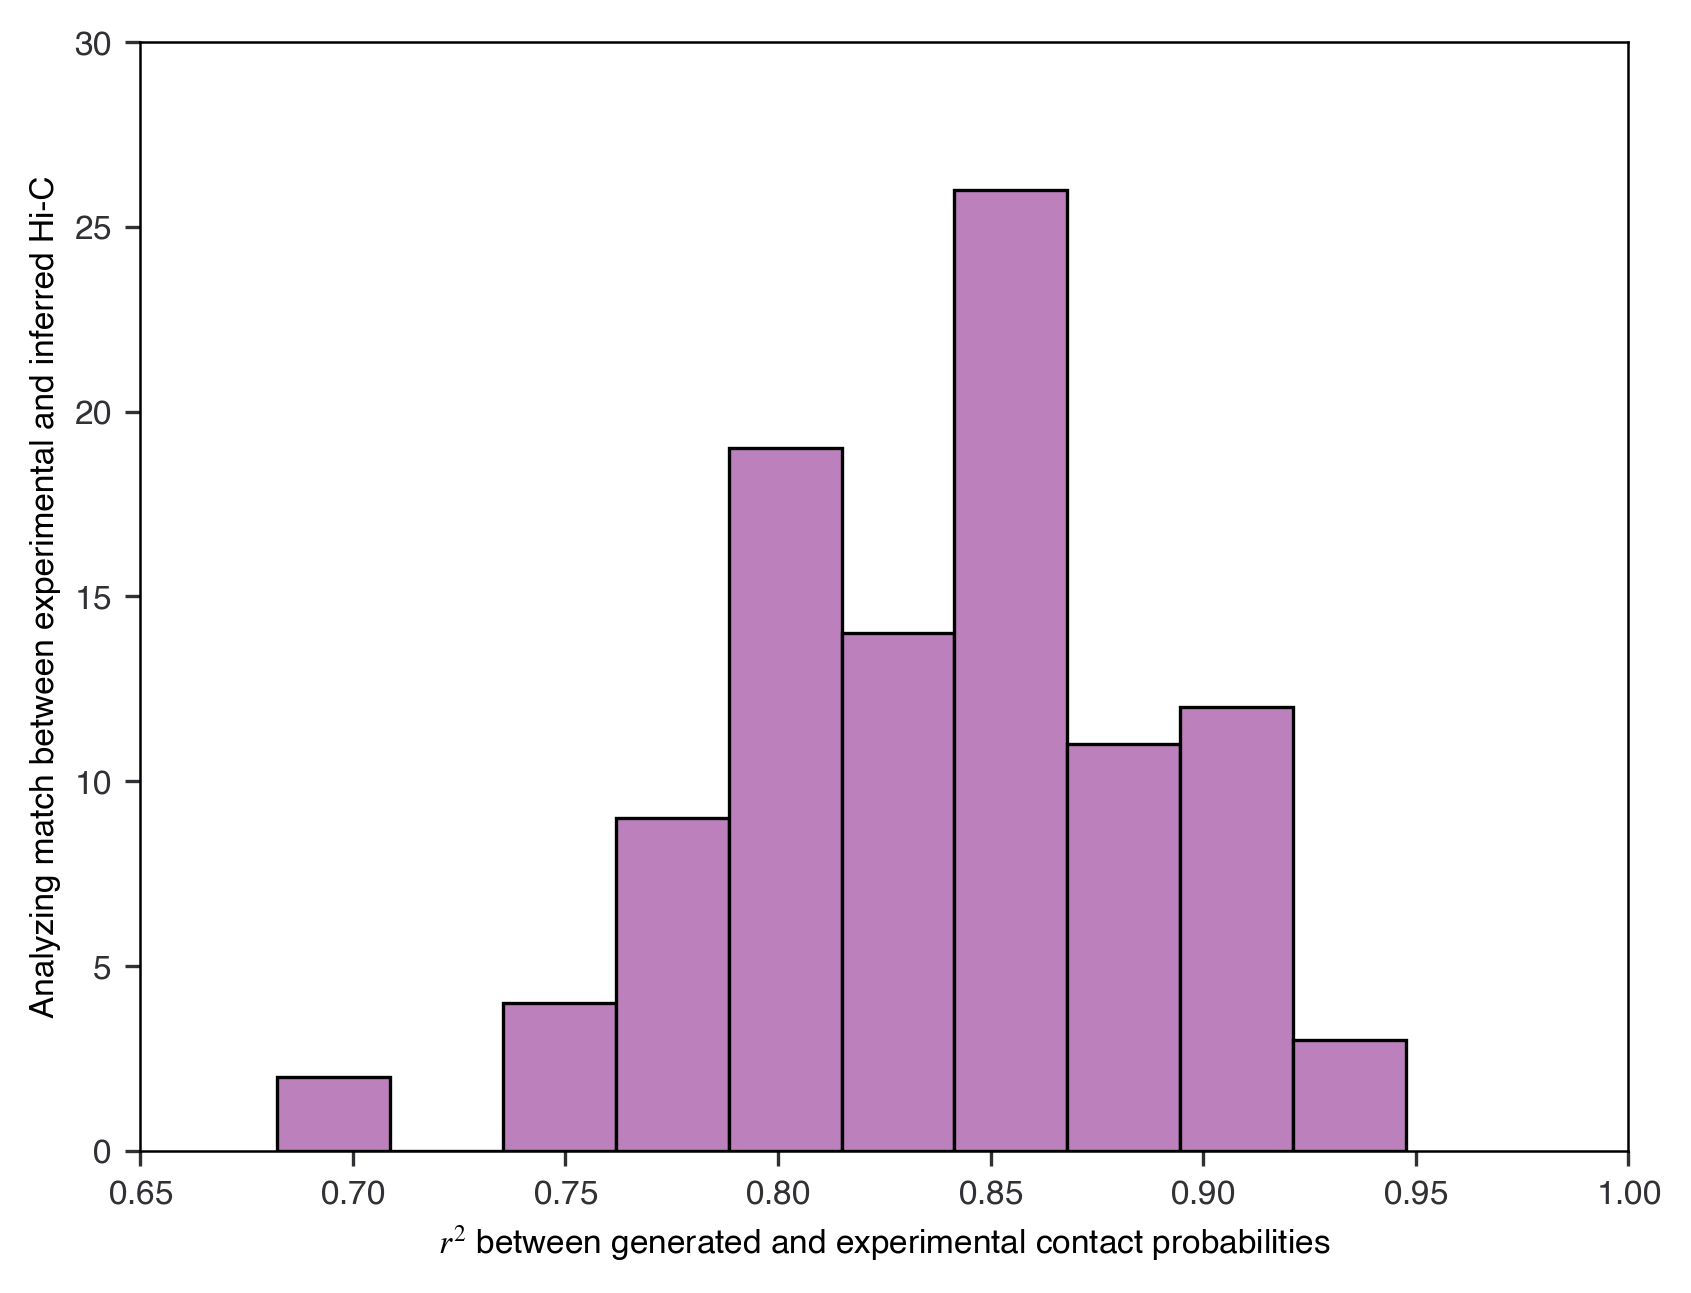

In [158]:
plt.hist(r2_vals.numpy())#,density=True)
plt.xlabel('$r^2$ between generated and experimental contact probabilities')
plt.ylabel('Number of regions')
plt.ylabel('Analyzing match between experimental and inferred Hi-C')

(array([ 2.,  0.,  4.,  6., 13., 18., 18., 19., 14.,  6.]),
 array([0.62276475, 0.65529924, 0.68783374, 0.72036823, 0.75290273,
        0.78543722, 0.81797172, 0.85050621, 0.88304071, 0.9155752 ,
        0.9481097 ]),
 <BarContainer object of 10 artists>)

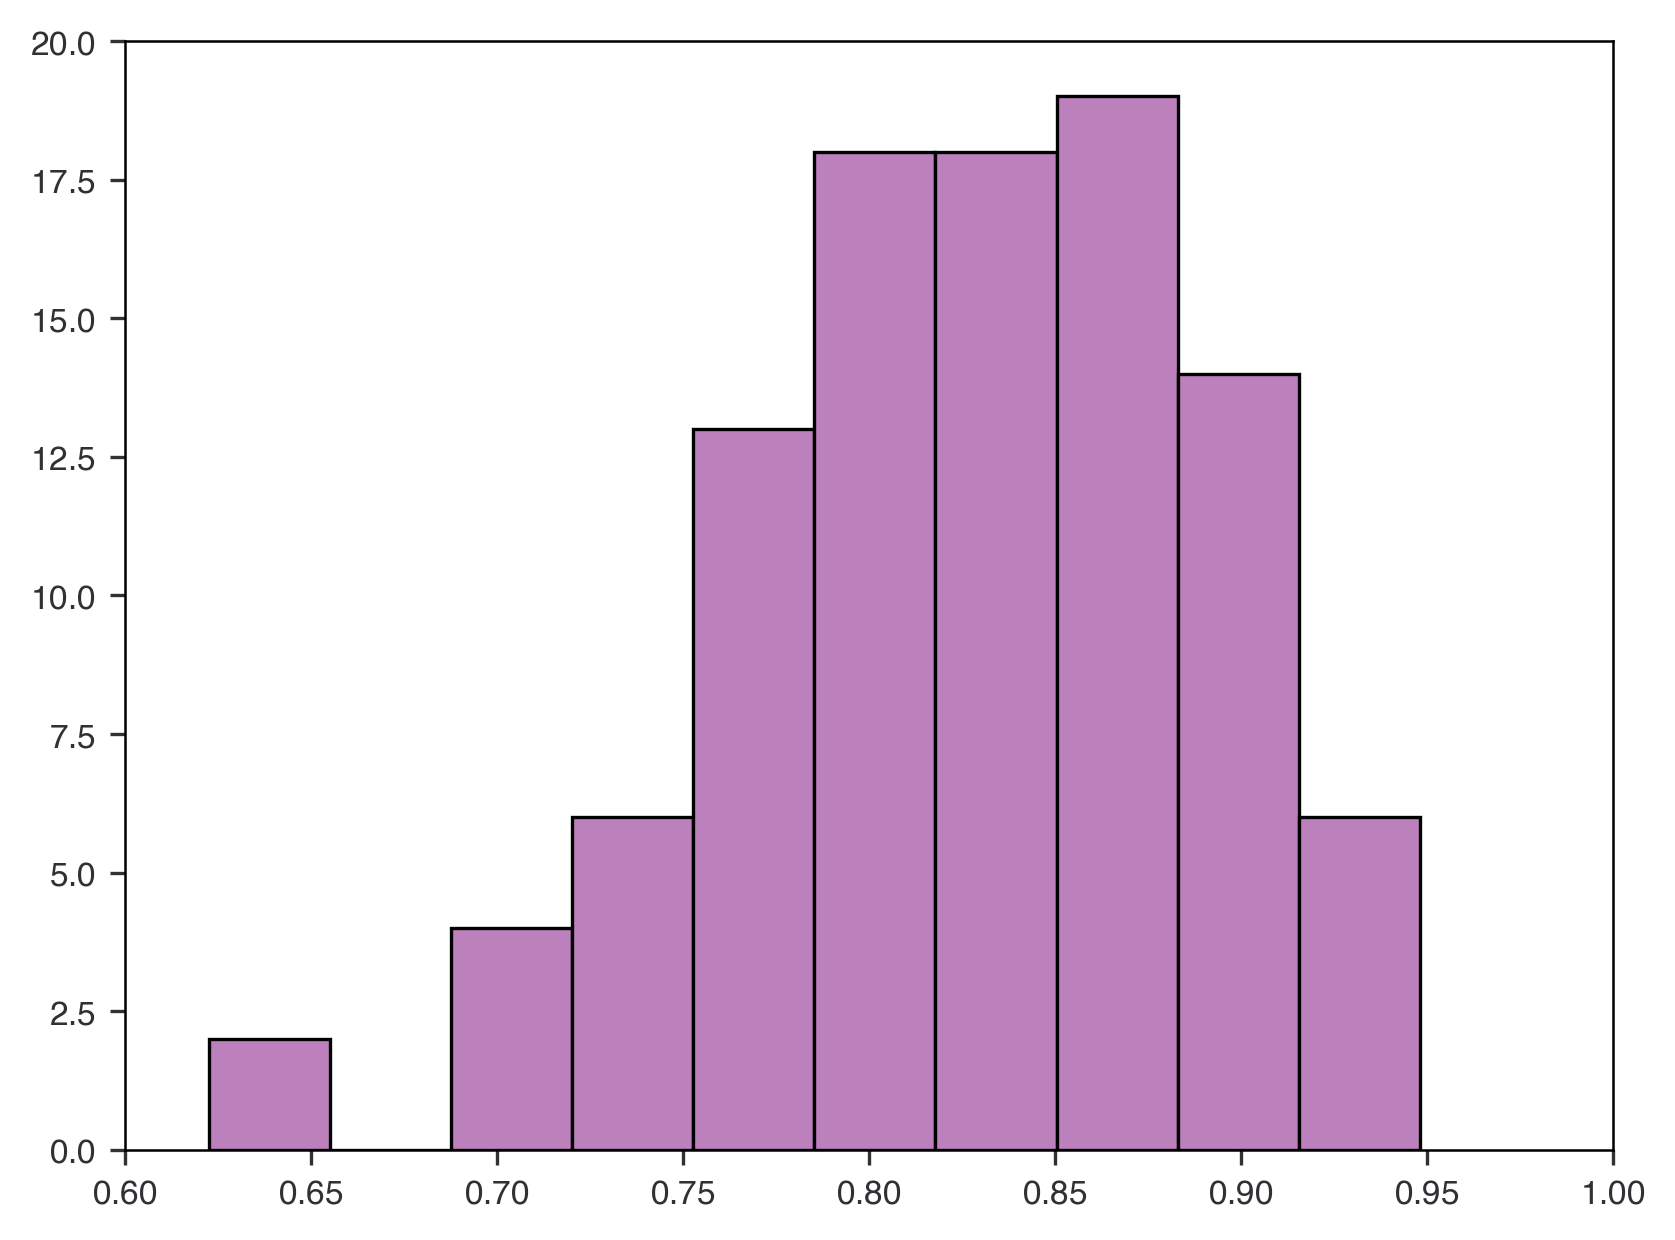

In [49]:
plt.hist(torch.tensor(r2_vals).numpy())

In [173]:
from tqdm.auto import tqdm

i,j = torch.triu_indices(64,64,1)
nearest_neighbors = torch.where(j-i==1)[0]
r2_vals_spatial = []
corrcoefs = []

files = {}
n = 0
for d in gm_directories:
    files[d] = [ f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]
    n+= len(files[d])

all_dists = []
all_probs = []
with tqdm(initial=0,total=n) as pbar:
    for d,fs in files.items():
        for f in fs:
            chrom,region_idx,start = parse_filename(f)
            
            exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
            exp_probs = exp_map.prob_map[i,j].log10()
            #exp_probs/= torch.nanmean(exp_probs[nearest_neighbors]).log10()
            idx = torch.where(exp_probs.isfinite())[0]
            
            exp_probs = exp_probs[idx]
            
            mean_dists = Coordinates(d+f).distances.mean.values[0,i,j] * 100

            #gen_map = get_gen_hic(coords,r_c=r_c,sigma=sigma)
            #gen_probs = gen_map.prob_map[i,j]
            #gen_probs = gen_map 
            
            #idx = torch.where(exp_probs.isfinite())[0]
            r2_vals_spatial.append(r2_score(mean_dists[idx],exp_probs))
            corrcoefs.append( torch.corrcoef(torch.stack([mean_dists[idx],exp_probs],dim=0))[0,1] )

            all_dists.append(mean_dists[idx])
            all_probs.append(exp_probs)

            pbar.update(1)
r2_vals_spatial = torch.tensor(r2_vals_spatial)
corrcoefs = torch.tensor(corrcoefs)
all_dists = torch.cat(all_dists)
all_probs = torch.cat(all_probs)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Correlation between mean distance and experimental contact probability')

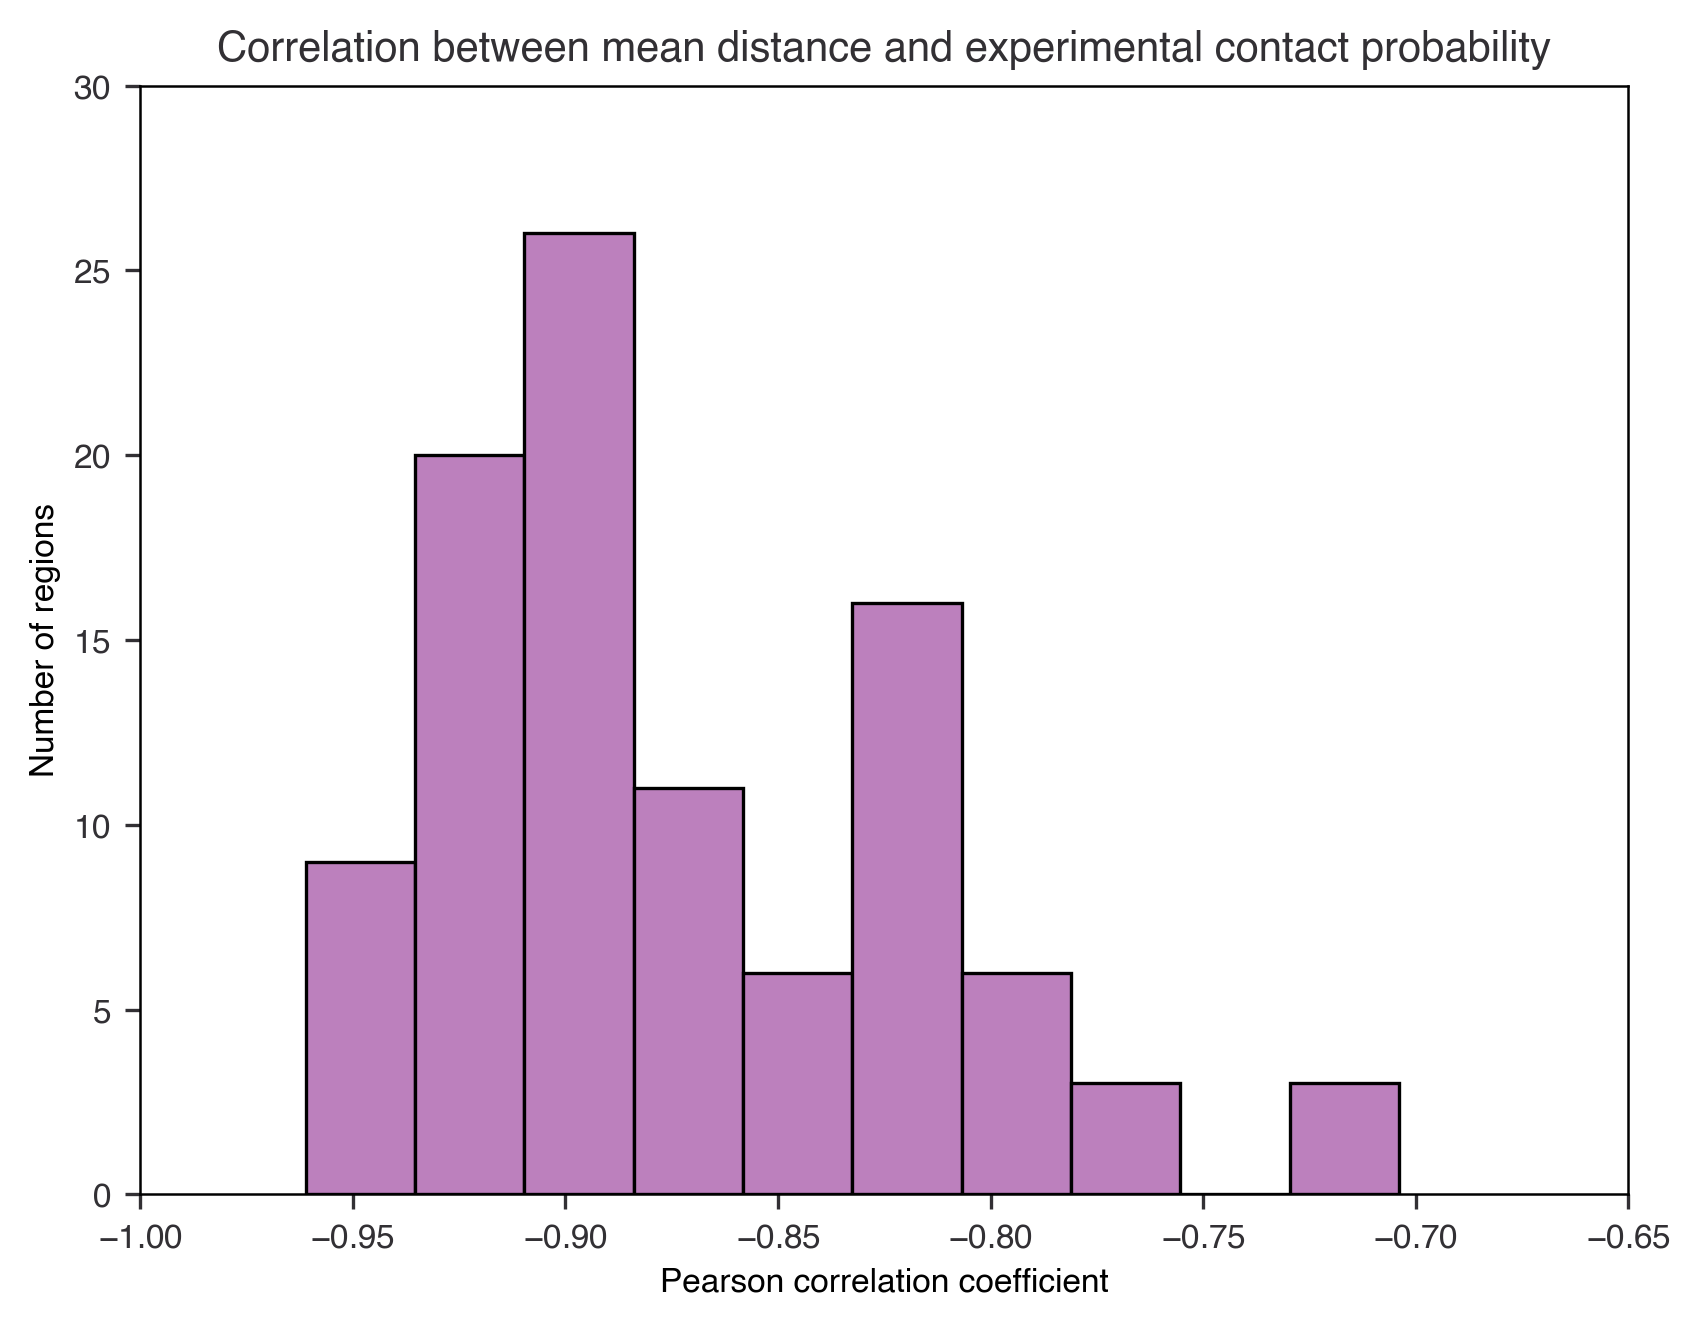

In [176]:
plt.hist(corrcoefs)
plt.xlabel('Pearson correlation coefficient')
plt.ylabel('Number of regions')
plt.title('Correlation between mean distance and experimental contact probability')

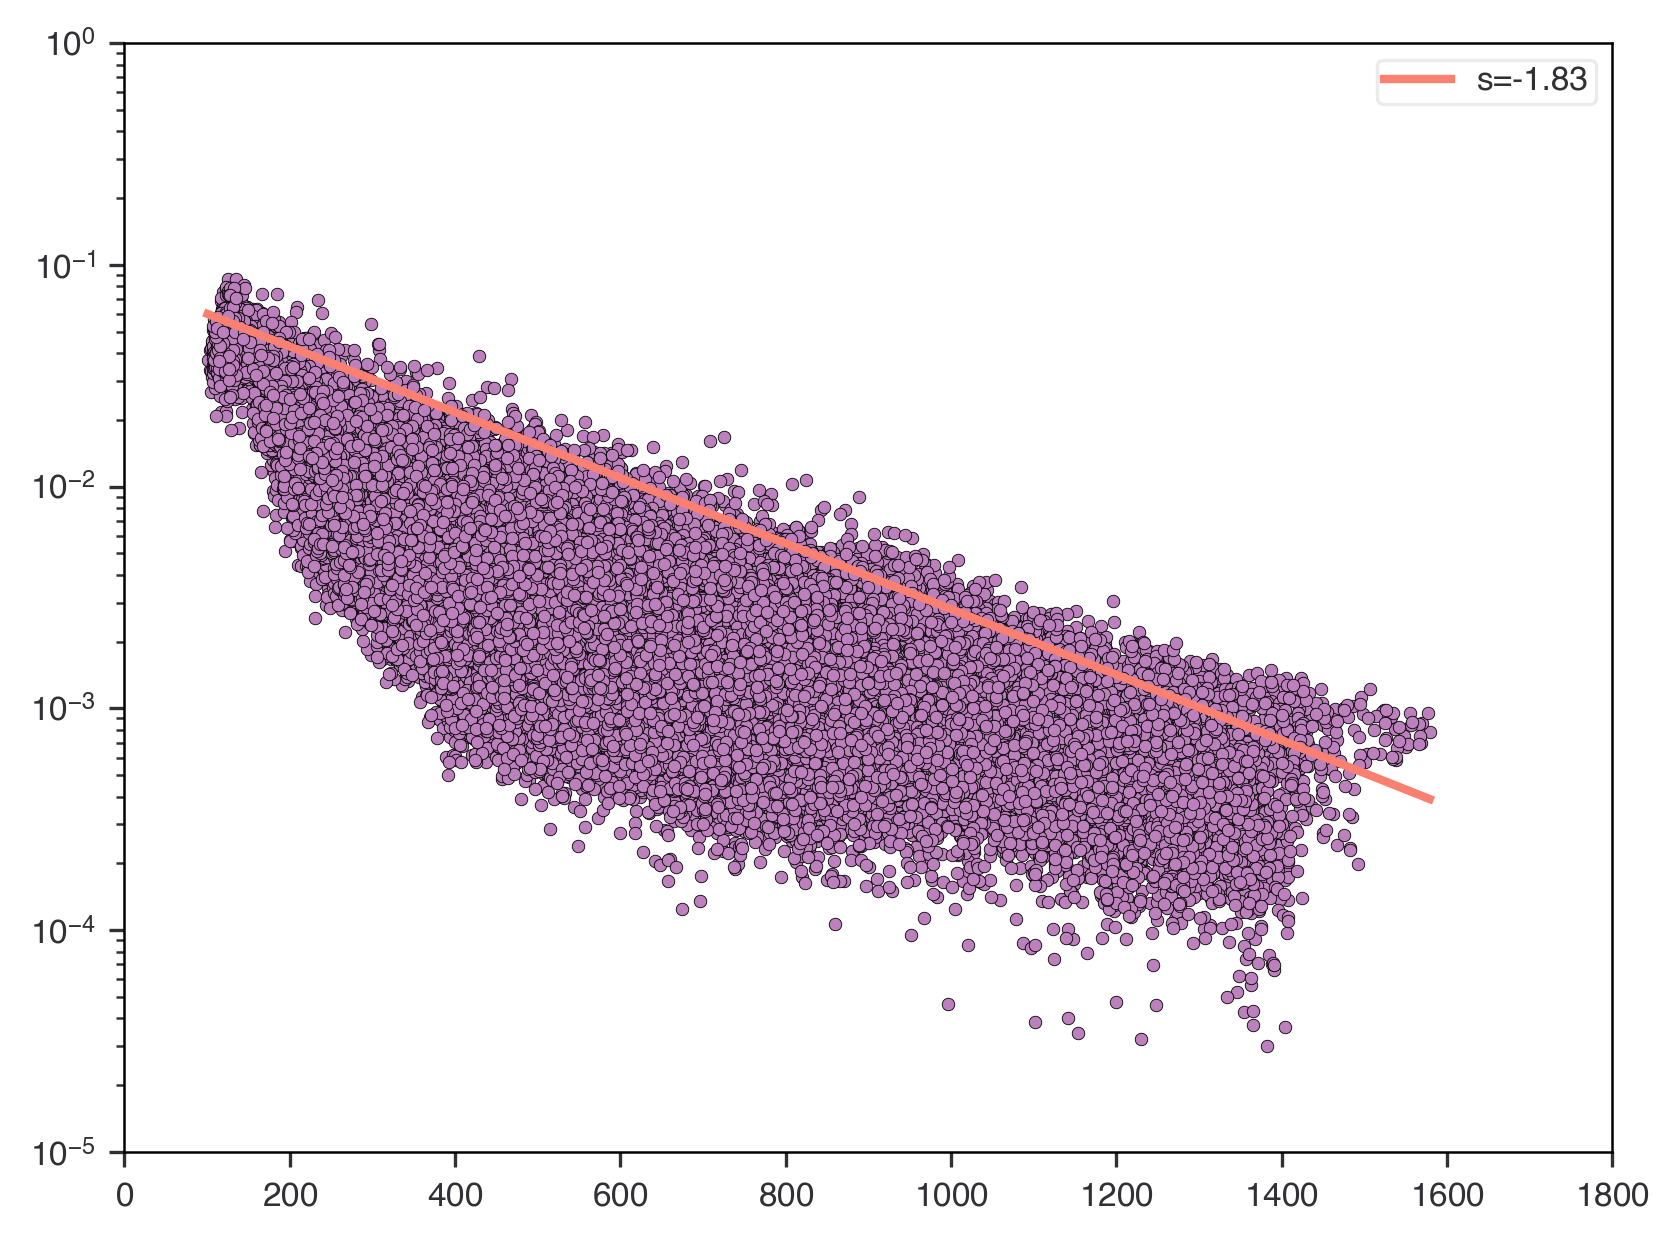

In [175]:
import numpy as np

#m,b = np.polyfit(mean_dists[idx].log10().cpu().numpy(),exp_probs.cpu().numpy(),1)
m,b = np.polyfit(all_dists.log10().cpu().numpy(),all_probs.cpu().numpy(),1)

#x = [mean_dists[idx].min(),mean_dists[idx].max()]
x = [all_dists.min(),all_dists.max()]
y = [ 10**(m*(xx.log10())+b) for xx in x ]

#plt.plot(mean_dists[idx].cpu().numpy(),(10**exp_probs).cpu().numpy(),'.') 
plt.plot(all_dists.cpu().numpy(),(10**all_probs).cpu().numpy(),'.') 
plt.plot(x,y,label=f's={round(m,3)}')
plt.yscale('log')
plt.legend()

In [183]:
torch.where( corrcoefs==corrcoefs.min() )

(tensor([72]),)

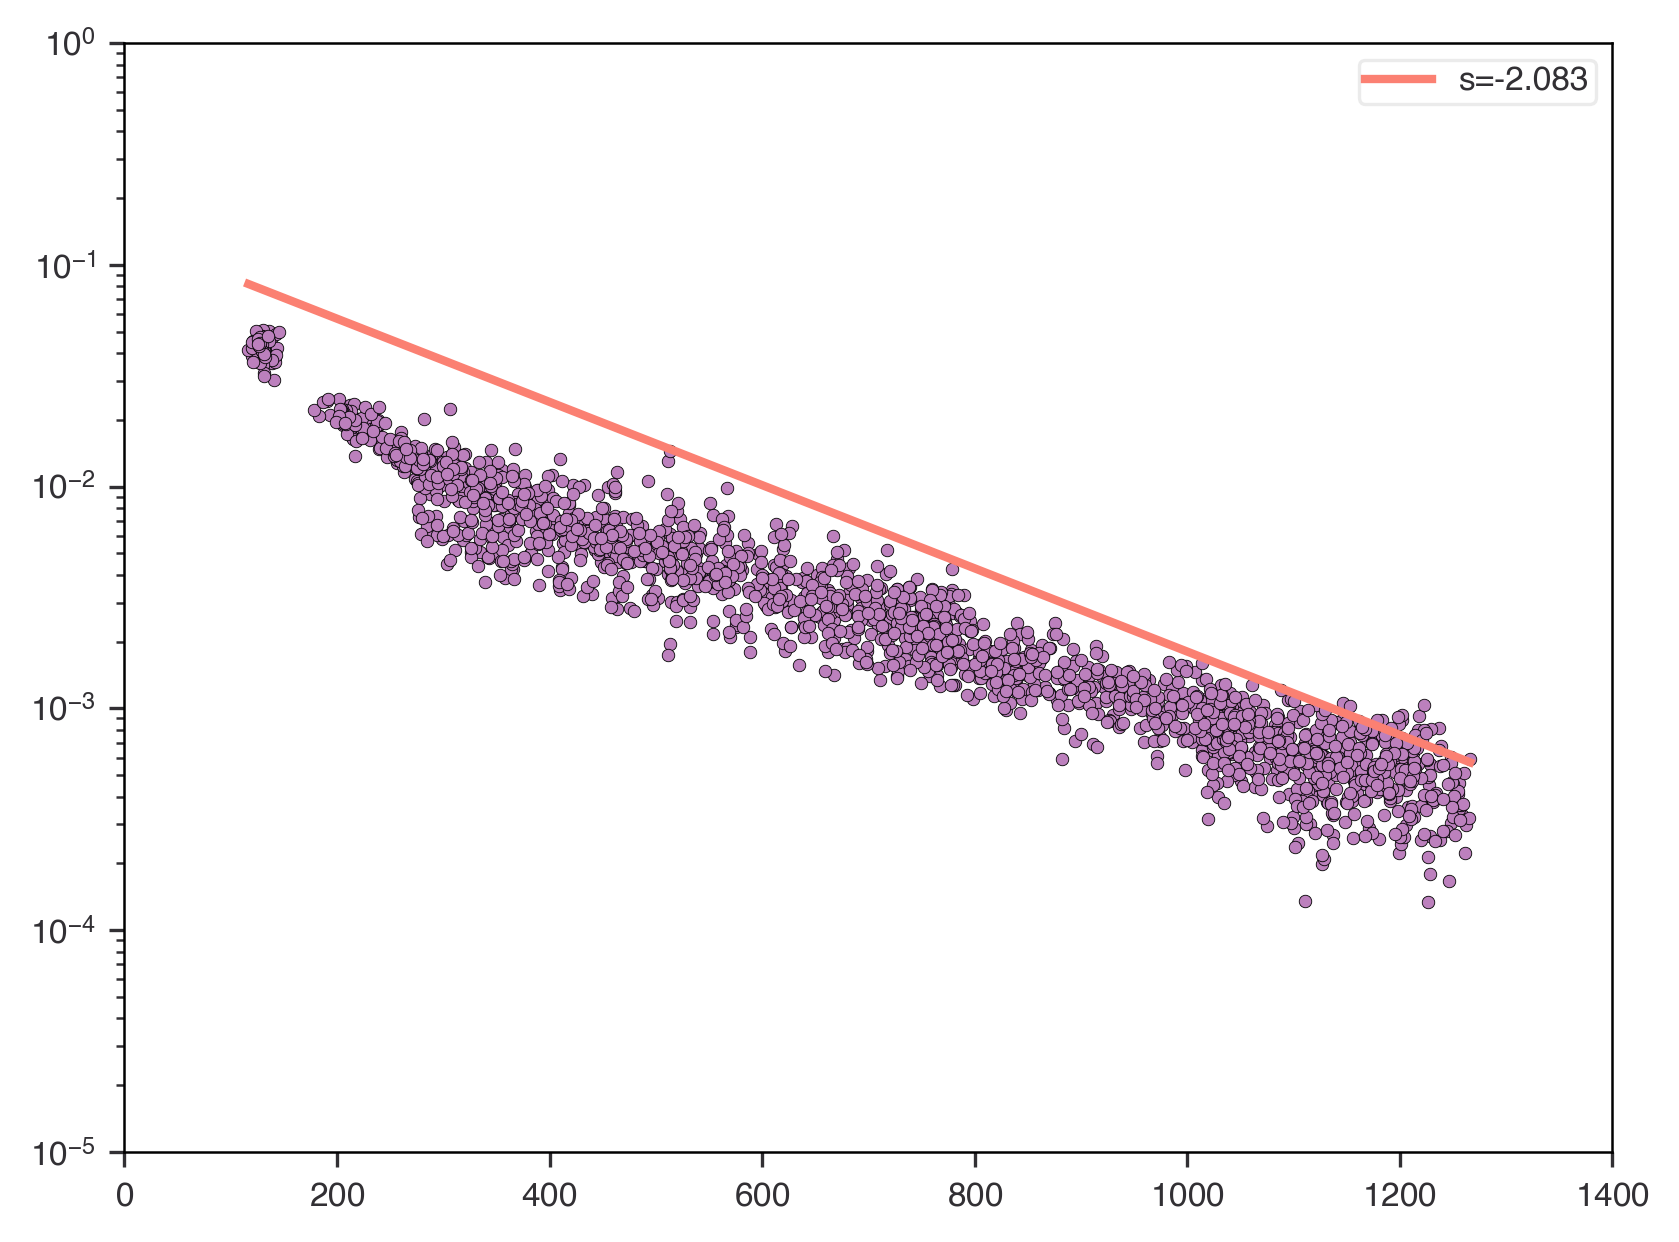

In [185]:
i,j = torch.triu_indices(64,64,1)
nearest_neighbors = torch.where(j-i==1)[0]

n=0
ii=72
for d in files:
    for f in files[d]:
        if n == ii:
            chrom,region_idx,start = parse_filename(f)
            
            exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
            exp_probs = exp_map.prob_map[i,j].log10()
            #exp_probs/= torch.nanmean(exp_probs[nearest_neighbors]).log10()
            idx = torch.where(exp_probs.isfinite())[0]
            exp_probs = exp_probs[idx]
            
            mean_dists = (Coordinates(d+f).distances.mean.values[0,i,j] * 100)
        n+=1
        if n > ii:
            break
    if n > ii:
        break
            
import numpy as np

m,b = np.polyfit(mean_dists[idx].log10().cpu().numpy(),exp_probs.cpu().numpy(),1)

x = [mean_dists[idx].min(),mean_dists[idx].max()]
y = [ 10**(m*(xx.log10())+b) for xx in x ]

plt.plot(mean_dists[idx].cpu().numpy(),(10**exp_probs).cpu().numpy(),'.') 
plt.plot(x,y,label=f's={round(m,3)}')
plt.yscale('log')
plt.legend()